In [1]:
#@title Upgrade pip, mount Google Drive
!pip install --upgrade pip setuptools wheel

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Mounted at /content/drive


In [2]:
#@title Find session ip
import subprocess

command = "hostname"
result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, universal_newlines=True)

session_ip = result.stdout.strip()

In [3]:
#@title Install HBse

%%shell
apt-get update
npm install -g localtunnel

if [ -f "hbase-2.5.3-bin.tar.gz" ]; then
    echo "File exists, skipping download"
else
  # https://hbase.apache.org/downloads.html
  wget https://dlcdn.apache.org/hbase/2.5.3/hbase-2.5.3-bin.tar.gz  
  tar -xzf hbase-2.5.3-bin.tar.gz 
fi

if [ -d "/opt/hbase-2.5.3" ]; then
    echo "HBase exists, skipping move"
else
    mv hbase-2.5.3 /opt/
fi

echo export JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64 >> /opt/hbase-2.5.3/conf/hbase-env.sh

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,027 kB]
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,590 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:

In [4]:
#@title Run HBase

%%shell
session_ip=$(hostname)
HBASE_LOG_DIR=./log/hbase /opt/hbase-2.5.3/bin/start-hbase.sh 
HBASE_LOG_DIR=./log/hbase /opt/hbase-2.5.3/bin/hbase-daemon.sh start thrift

# HBASE_LOG_DIR=./log/hbase /opt/hbase-2.5.3/bin/hbase-daemon.sh stop thrift
# HBASE_LOG_DIR=./log/hbase /opt/hbase-2.5.3/bin/stop-hbase.sh

running master, logging to ./log/hbase/hbase--master-af44071999d7.out
running thrift, logging to ./log/hbase/hbase--thrift-af44071999d7.out


In [5]:
!ss -tulpn | grep 16010

In [6]:
%%shell
tmux new -d -s tunnel
tmux send-keys -t tunnel "lt --port 16010" C-m

In [7]:
!tmux capture-pane -t tunnel -pS -1000

lt --port 16010
/content# lt --port 16010
your url is: https://warm-trams-draw-34-70-227-224.loca.lt























The HBase dashboard should be available on the public url.

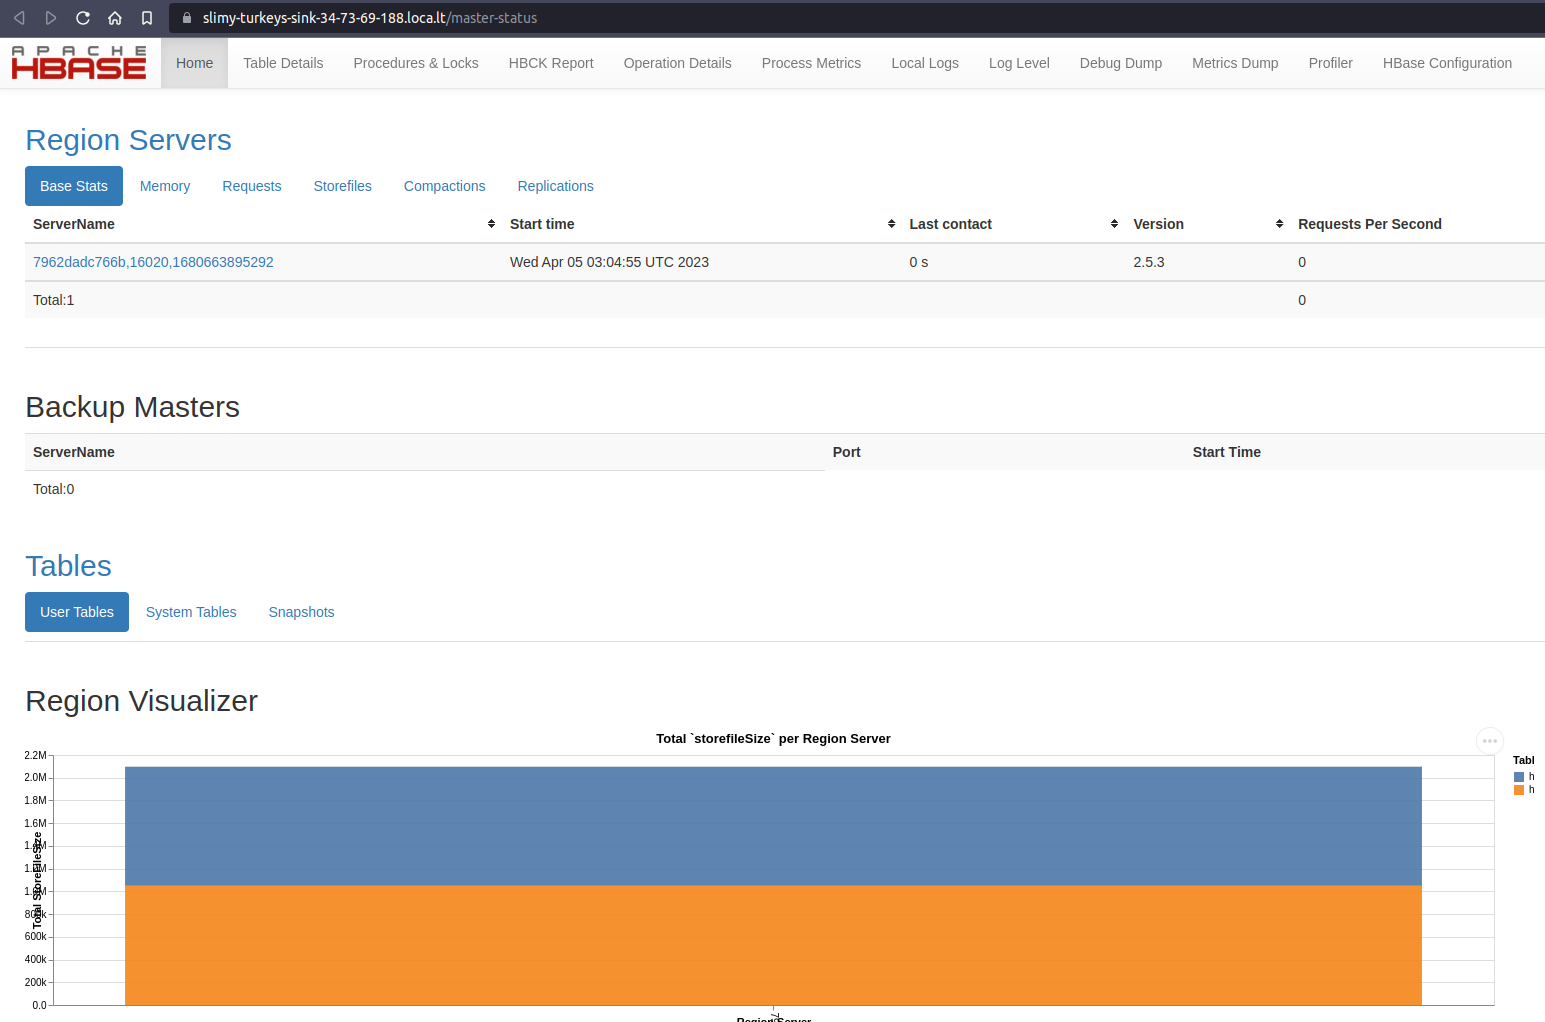

In [8]:
!pip install happybase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.4/643.4 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.4 MB/s eta 0:00:00
  Created wheel for happybase: filename=happybase-1.2.0-py2.py3-none-any.whl size=26621 sha256=2fd1cc8240d7adce3fb47a488e8227d7bf763a89b4e51206e6955694b42316a2
  Stored in directory: /root/.cache/pip/wheels/9e/00/b2/3a44a68da0a23b4f274c24f3bda10e84283d63fb8b8dfb3709
  Created wheel for thriftpy2: filename=thriftpy2-0.4.16-cp39-cp39-linux_x86_64.whl size=1210616 sha256=57f02bd7cec4033babc83cec46122f64e7d5d8a6a7a276e41cdb5cbc8f954634
  Stored in directory: /root/.cache/pip/wheels/88/a4/d5/907737b4c175aec82087b815fa93a8afea5c6c5a3e7bb748b9
Successfully built happybase thrift

In [10]:
import happybase

table_name = 'user_data'
connection = happybase.Connection(session_ip)
connection.create_table(table_name, {'info': dict(max_versions=10)})

# get a reference to the table
table = connection.table(table_name)

# define some example user data
user_data = [
    {'id': 'user_1', 'name': 'Pikachu', 'age': '35'},
    {'id': 'user_2', 'name': 'Charmander', 'age': '28'},
    {'id': 'user_3', 'name': 'Squirtle', 'age': '42'}
]

# insert the user data into the table
for user in user_data:
    row_key = user['id']
    data = {
        'info:name': user['name'],
        'info:age': user['age']
    }
    table.put(row_key, data)

# retrieve a user's data by their ID
user_id = 'user_1'
user_row = table.row(user_id)
user_name = user_row[b'info:name'].decode('utf-8')
user_age = user_row[b'info:age'].decode('utf-8')

print(f"{user_name} is {user_age} years old")


Pikachu is 35 years old


In [11]:
# connect to HBase
connection = happybase.Connection(session_ip)

# create a table
table_name = 'example_table'
column_family = {
    'data': dict(max_versions=10),
    'metadata': dict(max_versions=1)
}
connection.create_table(table_name, column_family)

# get a reference to the table
table = connection.table(table_name)

# insert some data into the table
row_key = 'example_row'
data = {
    'data:column1': 'value1',
    'metadata:created_at': '2022-04-04'
}
table.put(row_key, data)


# list tables
table_names = connection.tables()

# print table names
print("Tables in HBase:")
for table_name in table_names:
    print(table_name.decode('utf-8'))

# close the connection
connection.close()


Tables in HBase:
example_table
user_data
